In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## Day 25 Lecture 2 Assignment

In this assignment, we will extend a previous binary model to a multinomial case with three classes. We will use the FIFA soccer ratings dataset loaded below and analyze the model generated for this dataset.

In [26]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from mlxtend.plotting import plot_decision_regions

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [14]:
def remove_correlated_features(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (
                corr_matrix.columns[j] not in col_corr
            ):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    print(f"Deleted {colname} from dataset.")
                    del dataset[colname]

    return dataset

<IPython.core.display.Javascript object>

In [4]:
soccer_data = pd.read_csv(
    "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/fifa_ratings.csv"
)

<IPython.core.display.Javascript object>

In [5]:
soccer_data.head()

,ID,Name,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,158023,L. Messi,94,84,95,70,90,86,97,93,...,94,48,22,94,94,75,96,33,28,26
1,20801,Cristiano Ronaldo,94,84,94,89,81,87,88,81,...,93,63,29,95,82,85,95,28,31,23
2,190871,Neymar Jr,92,79,87,62,84,84,96,88,...,82,56,36,89,87,81,94,27,24,33
3,192985,K. De Bruyne,91,93,82,55,92,82,86,85,...,91,76,61,87,94,79,88,68,58,51
4,183277,E. Hazard,91,81,84,61,89,80,95,83,...,80,54,41,87,89,86,91,34,27,22


<IPython.core.display.Javascript object>

Our response for our logistic regression model is going to be a new column, "RankingTier", that contains three categories:

- High: Overall score > 75
- Middle: Overall score between 65 and 75
- Low: Overall score < 65

In [9]:
soccer_data["Overall"][3]

91

<IPython.core.display.Javascript object>

In [12]:


soccer_data["RankingTier"] = "High" 
soccer_data.loc[soccer_data["Overall"] <= 75, "RankingTier"] = "Middle" 
soccer_data.loc[soccer_data["Overall"] <= 65, "RankingTier"] = "Low"

soccer_data["RankingTier"].value_counts(normalize=True)


Middle    0.471219
Low       0.441012
High      0.087768
Name: RankingTier, dtype: float64

<IPython.core.display.Javascript object>

In [13]:
soccer_data["RankingTier"]

0        High
1        High
2        High
3        High
4        High
         ... 
16117     Low
16118     Low
16119     Low
16120     Low
16121     Low
Name: RankingTier, Length: 16122, dtype: object

<IPython.core.display.Javascript object>

The next few steps until model training are the same as before: identify and remove highly correlated features, and split the data into a training set (80%) and a test set (20%).

In [18]:
# answer goes here
soccer_clean = remove_correlated_features(soccer_data.drop(columns = 'Overall'), 0.9)
X = soccer_clean.drop(columns=['ID', 'Name', 'RankingTier'])
y = soccer_clean['RankingTier']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)


Deleted StandingTackle from dataset.
Deleted SlidingTackle from dataset.


<IPython.core.display.Javascript object>

Index(['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking'],
      dtype='object')

<IPython.core.display.Javascript object>

Fit a multinomial logistic regression model using the statsmodels package and print out the coefficient summary. What is the "reference" tier chosen by the model? How do we interpret the coefficients - for example, how does the intepretation of the "Reactions" coefficient for RankingTier=Low differ from the "Reactions" coefficient for RankingTier=Middle?

In [27]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<IPython.core.display.Javascript object>

In [28]:
# answer goes here
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [29]:
model.score(X_train, y_train)

0.8387221834535163

<IPython.core.display.Javascript object>

In [30]:
pd.DataFrame(model.coef_, columns=X.columns)

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking
0,-0.012600,0.428385,0.641045,1.507834,-0.193792,-0.009701,-0.005704,0.136179,-0.009085,1.519955,...,-0.028520,0.343675,-0.460340,0.150323,-0.336080,-0.654128,-0.515728,0.092707,1.159682,0.407003
1,-0.099781,-0.360203,-0.688774,-1.166316,0.185140,0.062100,-0.002667,-0.121508,-0.023507,-1.306000,...,-0.032285,-0.305983,0.323235,-0.125766,0.214683,0.513992,0.475146,-0.138756,-1.044233,-0.350006
2,0.112381,-0.068182,0.047730,-0.341518,0.008652,-0.052399,0.008371,-0.014671,0.032592,-0.213955,...,0.060806,-0.037692,0.137106,-0.024558,0.121396,0.140137,0.040581,0.046049,-0.115449,-0.056997


<IPython.core.display.Javascript object>

To evaluate test error using cross-validation, we will switch back to scikit-learn. Estimate the test error of this multinomial logistic regression model using 10-fold CV.

Note: scikit-learn's LogisticRegression() function can handle both binary and multinomial regression, and it is automatically able to determine which is appropriate based on the y_train array that is passed. You should be able to reuse previous code with minimal changes required.

In [33]:
# answer goes here
cv_scores = cross_val_score(model, X_train, y_train, cv = 10)




<IPython.core.display.Javascript object>

In [34]:
cv_scores.mean()

0.8360863838923269

<IPython.core.display.Javascript object>

As we did in the previous exercise, train a multinomial logistic regression on the training data, make predictions on the 20% holdout test data, then:

- Determine the precision, recall, and F1-score of our model using a cutoff/threshold of 0.5 (hint: scikit-learn's *classification_report* function may be helpful)
- Plot or otherwise generate a confusion matrix
- Plot the ROC curve for our logistic regression model

Comment on the performance of the model.

In [36]:
# answer goes here
y_pred = model.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
pd.DataFrame(
    confusion_mat,
    columns=["predicted_0 ", "predicted_1", 'predicted_2'],
    index=["actual_0", "actual_1", 'actual_2'],
)



,predicted_0,predicted_1,predicted_2
actual_0,208,0,69
actual_1,0,1196,219
actual_2,42,192,1299


<IPython.core.display.Javascript object>

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.83      0.75      0.79       277
         Low       0.86      0.85      0.85      1415
      Middle       0.82      0.85      0.83      1533

    accuracy                           0.84      3225
   macro avg       0.84      0.81      0.83      3225
weighted avg       0.84      0.84      0.84      3225



<IPython.core.display.Javascript object>

In [38]:
y_prob = model.predict_proba(X_test)
prob_df = pd.DataFrame(
    y_prob, columns=["prob_0", "prob_1", "prob_2"], index=y_test.index
)
prob_df

,prob_0,prob_1,prob_2
5066,2.075461e-03,0.203957,0.793967
1358,6.302120e-02,0.005722,0.931257
11511,1.818118e-06,0.849654,0.150344
15981,3.766877e-11,0.998418,0.001582
4010,3.660878e-04,0.202833,0.796801
...,...,...,...
11400,2.291947e-07,0.935042,0.064958
15160,9.428113e-07,0.908447,0.091552
7779,3.699405e-04,0.186305,0.813325
14119,3.284626e-09,0.985945,0.014055


<IPython.core.display.Javascript object>

In [41]:
prob_df["is_0"] = (y_test == 0).astype(int)
prob_df["is_1"] = (y_test == 1).astype(int)
prob_df["is_2"] = (y_test == 2).astype(int)
prob_df.head()

,prob_0,prob_1,prob_2,is_0,is_1,is_2
5066,2.075461e-03,0.203957,0.793967,0,0,0
1358,6.302120e-02,0.005722,0.931257,0,0,0
11511,1.818118e-06,0.849654,0.150344,0,0,0
15981,3.766877e-11,0.998418,0.001582,0,0,0
4010,3.660878e-04,0.202833,0.796801,0,0,0


<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


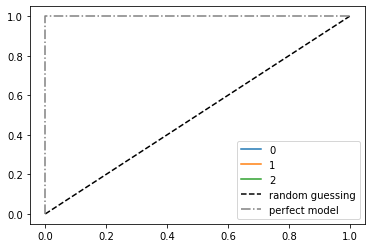

<IPython.core.display.Javascript object>

In [40]:
for label in [0, 1, 2]:
    fpr, tpr, thresholds = roc_curve(prob_df[f"is_{label}"], prob_df[f"prob_{label}"])
    plt.plot(fpr, tpr, label=label)

plt.plot([0, 1], [0, 1], "--", c="black", label="random guessing")
plt.plot([0, 0, 1], [0, 1, 1], "-.", c="gray", label="perfect model")
plt.legend()

plt.show()

In [42]:
y_prob_hi = y_prob[:, 0]
y_prob_lo = y_prob[:, 1]
y_prob_mid = y_prob[:, 2]

<IPython.core.display.Javascript object>

In [43]:
roc_auc_score(y_test == "High", y_prob_hi)

0.9831630328828455

<IPython.core.display.Javascript object>

In [44]:
roc_auc_score(y_test == "Low", y_prob_lo)

0.951297268805029

<IPython.core.display.Javascript object>

In [45]:
roc_auc_score(y_test == "Middle", y_prob_mid)

0.9186613957089037

<IPython.core.display.Javascript object>

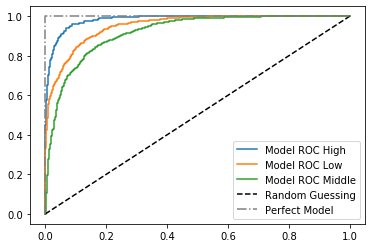

<IPython.core.display.Javascript object>

In [46]:
hi_fpr, hi_tpr, _ = roc_curve(y_test == "High", y_prob_hi)
lo_fpr, lo_tpr, _ = roc_curve(y_test == "Low", y_prob_lo)
mid_fpr, mid_tpr, _ = roc_curve(y_test == "Middle", y_prob_mid)

plt.plot(hi_fpr, hi_tpr, label="Model ROC High")
plt.plot(lo_fpr, lo_tpr, label="Model ROC Low")
plt.plot(mid_fpr, mid_tpr, label="Model ROC Middle")
plt.plot([0, 1], [0, 1], "--", c="black", label="Random Guessing")
plt.plot([0, 0, 1], [0, 1, 1], "-.", c="gray", label="Perfect Model")
plt.legend()
plt.show()